# Mobilenet V2 - Stanford Dogs dataset classification with transfer learning



#### Classifying 120 classes without pre-trained models from *keras.applications* can be a challenging task. In this notebook, I am trying to accomplish this by using MobileNet architectures to create a deep enough CNN but as fast as possible CNN for this task. Feedback is welcome!
#### What I did with this model:

* Transfer learning based on MobileNet CNN but the size is reduced substantially to save training time
* Using NAdam optimization (Adam with Nesterov)


In [1]:
import os
import glob
import warnings
import math
import cv2
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications 
from tensorflow.keras import optimizers

from tensorflow.keras import backend as k 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

from sklearn.metrics import classification_report

In [2]:
###################
image_path = '/media/marco/DATA/OC_Machine_learning/section_6/DATA/Images/'
num_of_categories = 120
image_size = 224
batch_size = 64
###################

In [3]:
train_size = int(20580*0.8)
test_size = int(20580*0.2)

In [4]:
### Image loading method 1: image_datagen and flow_from_directory



def image_datagen_load():

    datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=30, width_shift_range=0.2,
        height_shift_range=0.2, brightness_range=[0.9,1.1], zoom_range=0.1, fill_mode='constant', cval=0.0, horizontal_flip=True, 
        rescale=1/255., preprocessing_function = preprocessImage, validation_split=0.2, dtype='float32')

    train_datagen = datagen.flow_from_directory(image_path,
        target_size=(image_size, image_size), color_mode='rgb', classes=None, interpolation='hamming',
        class_mode='categorical', batch_size=batch_size, shuffle=True, subset='training')

    test_datagen = datagen.flow_from_directory(image_path,
        target_size=(image_size, image_size), color_mode='rgb', classes=None, interpolation='hamming',
        class_mode='categorical', batch_size=batch_size, shuffle=False, subset='validation')
    
    return train_datagen, test_datagen

In [5]:
# image loading 

train, test = image_datagen_load()

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [6]:
filters = 32
kernel_size = (3,3)
stride = (1,1)
pool_size = (3,3)
l2 = tf.keras.regularizers.l2(0.00005)

In [7]:
base_model = applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3), )
base_model.trainable = True

seed = 42

model = Sequential()
model.add(base_model)

model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.2))
#model.add(Dense(num_of_categories, activation='softmax',  kernel_initializer=glorot_uniform(seed), bias_initializer='zeros'))
model.add(Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(seed), bias_initializer='zeros'))


model.add(Dense(num_of_categories, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros'))

#model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(lr=0.0001)
#SGD(lr=1.62e-2, decay=1e-6, momentum=0.9, nesterov=True)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1280)              1639680   
_________________________________________________________________
dense_1 (Dense)              (None, 120)               153720    
Total params: 4,056,504
Trainable params: 4,019,832
Non-trainable params: 36,672
_________________________________________

[0.0001, 0.00014715177646857695, 0.00030122571620038027, 0.00043307290635716066, 0.0005130312413993676, 0.0005377003383729307, 0.0005178851256927623, 0.00046888035555159497, 0.00040492292381893205, 0.00033689734995427336, 0.00027197463922978366, 0.00021416418806397342, 0.00016515279534858634, 0.00012511020567407963, 9.333298746244693e-05, 6.870274619443443e-05, 4.998200484746474e-05, 3.5986298871675764e-05, 2.567043505998692e-05, 1.815997190499394e-05, 1.815997190499394e-05, 1.815997190499394e-05, 1.815997190499394e-05, 1.815997190499394e-05, 1.815997190499394e-05, 1.815997190499394e-05, 1.815997190499394e-05, 1.815997190499394e-05, 1.815997190499394e-05, 1.815997190499394e-05]


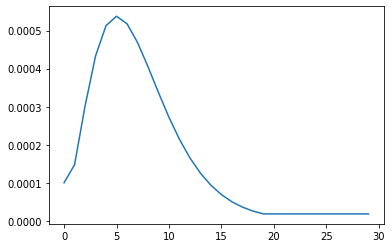

In [8]:
###################
total_epoch = 50
learning_rate_init = 0.0001
###################

def scheduler_2(epoch):
    epoch += 1
   
    if epoch == 1:
        return learning_rate_init
    
    elif epoch >= 2 and epoch <= 20:
        return (0.5*epoch**3)*math.exp(-0.5*epoch)*learning_rate_init
    
    else:
        return scheduler_2(20-1)
    

stage = [i for i in range(0,30)]
learning_rate = [scheduler_2(x) for x in stage]
plt.plot(stage, learning_rate)
print(learning_rate)

In [9]:
#model = keras.Model(inputs=base_model.input, outputs = predictions, name='model')
loss = keras.losses.CategoricalCrossentropy()

metrics = [keras.metrics.CategoricalAccuracy(name='acc')]
model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

#print(model.summary())

In [10]:
scheduler = keras.callbacks.LearningRateScheduler(scheduler_2, verbose=1)
earlystop = keras.callbacks.EarlyStopping(monitor='val_acc',mode='max',verbose=1,patience=5,restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint('temp',save_weights_only=True,monitor='val_acc',mode='max',save_best_only=True)


In [11]:
%%time

history = model.fit(train, batch_size=batch_size, epochs=total_epoch, callbacks=[scheduler,earlystop,checkpoint],
                    validation_data=test, steps_per_epoch=train_size//batch_size, validation_steps=test_size//batch_size)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/50
257/257 [==============================] - 1164s 5s/step - loss: 2.4431 - acc: 0.4256 - val_loss: 5.0202 - val_acc: 0.0083 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00014715177646857695.
Epoch 2/50
 63/257 [======>.......................] - ETA: 13:34 - loss: 1.1333 - acc: 0.6671

KeyboardInterrupt: 

In [12]:
model.save('dog_breed_mobilenetV2.h5', overwrite=True)
model.save_weights('dog_breed_mobilenetV2_weights.h5', overwrite=True)
print("Saved model to disk")

Saved model to disk


In [13]:
print('max validation accuracy during training: ',max(history.history['val_acc']))
print('min validation loss during training: ',min(history.history['val_loss']))

NameError: name 'history' is not defined

In [ ]:
pred = model.predict(test, batch_size=batch_size, steps=test_size//batch_size, verbose=1)
best_predictions = np.argmax(pred, axis=-1)
print("best_predictions ", best_predictions )


In [ ]:
class_to_id={}
id_to_class={}
for key, value in test.class_indices.items():
    class_to_id[key[10:]] = value
    id_to_class[value] = key[10:]

report = classification_report(test.classes, best_predictions, target_names=class_to_id)
print(report)

In [ ]:
plt.title('model accuracy')
plt.plot(history.history['acc'],label='train accuracy')
plt.plot(history.history['val_acc'],label='test accuracy')
plt.legend()
plt.show()

In [ ]:
plt.title('model loss')
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='test loss')
plt.legend()
plt.show()

In [ ]:
breed_list = os.listdir(image_path)
print("num. breeds total:", len(breed_list))
filtered_breeds = [breed.split('-',1)[1] for breed in breed_list] 

roundpred = np.around(pred, decimals=1)
df_pred = pd.DataFrame(roundpred, columns = filtered_breeds[:num_of_categories])
df_pred.head()


In [ ]:
df_breed_pred = df_pred.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=3)
df_breed_pred.columns = ['1st_prob_breed','2nd_prob_breed','3rd_prob_breed']
df_breed_pred.head()

In [ ]:
prob_df = df_pred.apply(np.sort, axis=1).apply(lambda df_pred: df_pred[-3:]).apply(pd.Series)
prob_df.columns = ['3rd_prob','2nd_prob','1st_prob']
prob_df = prob_df*100
prob_df = prob_df.astype(int)
prob_df = pd.concat([prob_df, df_breed_pred], axis=1)


In [ ]:


prob_df['final']= prob_df["1st_prob_breed"].astype(str) +" "+ prob_df["1st_prob"].astype(str)+"%, "+prob_df["2nd_prob_breed"].astype(str) +" "+ prob_df["2nd_prob"].astype(str)+"%, "+prob_df["3rd_prob_breed"].astype(str) +" "+ prob_df["3rd_prob"].astype(str)+"%"



In [ ]:

y_true_n = test.classes
#df_test = pd.DataFrame(y_true, columns = filtered_breeds[:num_of_categories])
#given_df = df_test.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=1)
#given_df.head()
y_true = [id_to_class[i] for i in y_true_n]
#print (','.join(y_true))
df_given = pd.DataFrame(y_true)

In [ ]:
import matplotlib.image as mpimg

plt.figure(1 , figsize = (19 , 10))
n = 0 
r = np.random.randint(low=1, high=100, size=9)
for i in r:
    n += 1 
    
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    name = test.filepaths[i]
    plt.imshow(mpimg.imread(name))
    plt.title(y_true[i])
 
    plt.xlabel(prob_df.iloc[i,6], wrap=True, color = "r")
    plt.xticks([]) , plt.yticks([])

plt.show()


In [ ]:
from PIL import Image
imageno=np.random.random_integers(low=0, high=test.samples)

name = test.filepaths[imageno]
print(name)
plt.imshow(mpimg.imread(name))

img = Image.open(test.filepaths[imageno]).resize((224, 224))
probabilities = model.predict(preprocess_input(np.expand_dims(img, axis=0)))
breed_list = tuple(zip(test.class_indices.values(), test.class_indices.keys()))

for i in probabilities[0].argsort()[-5:][::-1]: 
    print(probabilities[0][i], "  :  " , breed_list[i])